In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# GENERAL UTILITIES
import os
from glob import glob
import pandas as pd
from  tqdm.notebook import tqdm
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

# MODEL DEVELOPMENT DEPENDENCIES
import numpy as np
import pywt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


In [3]:
def load_data_1d(gt_file_path):

  labels = pd.read_csv(gt_file_path)
  train_data, test_data = train_test_split(labels, test_size=0.2)

  return train_data, test_data

In [4]:
gt_data_path = "/content/drive/MyDrive/BTP/soilmoisture_dataset.csv"

# Loading training raw data
train_data, test_data = load_data_1d(gt_data_path)

In [5]:
train_data.shape

(543, 129)

In [6]:
train_data.head()

,index,datetime,soil_moisture,soil_temperature,454,458,462,466,470,474,...,914,918,922,926,930,934,938,942,946,950
355,358,2017-05-17 12:34:14,28.41,40.4,0.118759,0.078395,0.067509,0.065628,0.064270,0.064089,...,0.202916,0.203044,0.203401,0.203076,0.203785,0.204855,0.206574,0.207443,0.207674,0.208173
637,640,2017-05-26 12:40:11,31.63,40.0,0.103609,0.066780,0.056235,0.052139,0.050315,0.049241,...,0.162598,0.163852,0.165356,0.166001,0.167204,0.168219,0.169505,0.170597,0.171334,0.172286
387,390,2017-05-24 11:36:16,34.59,35.7,0.090632,0.064046,0.057472,0.054662,0.054920,0.053862,...,0.168242,0.168110,0.167789,0.167497,0.167197,0.166908,0.167591,0.168233,0.167684,0.167705
96,98,2017-05-16 16:33:51,27.83,46.5,0.127048,0.084421,0.076076,0.073605,0.073218,0.073342,...,0.214202,0.213685,0.213900,0.213771,0.214525,0.214864,0.215287,0.215091,0.214935,0.214581
574,577,2017-05-26 10:22:28,35.96,34.8,0.083290,0.060933,0.053559,0.051812,0.051593,0.050417,...,0.160834,0.161444,0.161842,0.161626,0.161122,0.159732,0.158217,0.155154,0.153506,0.151597


In [30]:
y_train = train_data[['soil_temperature', 'soil_moisture']]
y_test = test_data[['soil_temperature', 'soil_moisture']]
X_train = train_data.drop(columns=['index', 'datetime', 'soil_moisture', 'soil_temperature'])
X_test = test_data.drop(columns=['index', 'datetime', 'soil_moisture', 'soil_temperature'])

In [31]:
X_train.head()

,454,458,462,466,470,474,478,482,486,490,...,914,918,922,926,930,934,938,942,946,950
355,0.118759,0.078395,0.067509,0.065628,0.064270,0.064089,0.063891,0.063265,0.063693,0.065307,...,0.202916,0.203044,0.203401,0.203076,0.203785,0.204855,0.206574,0.207443,0.207674,0.208173
637,0.103609,0.066780,0.056235,0.052139,0.050315,0.049241,0.049013,0.048878,0.049300,0.050442,...,0.162598,0.163852,0.165356,0.166001,0.167204,0.168219,0.169505,0.170597,0.171334,0.172286
387,0.090632,0.064046,0.057472,0.054662,0.054920,0.053862,0.054264,0.054556,0.055645,0.056424,...,0.168242,0.168110,0.167789,0.167497,0.167197,0.166908,0.167591,0.168233,0.167684,0.167705
96,0.127048,0.084421,0.076076,0.073605,0.073218,0.073342,0.073638,0.074354,0.075484,0.077800,...,0.214202,0.213685,0.213900,0.213771,0.214525,0.214864,0.215287,0.215091,0.214935,0.214581
574,0.083290,0.060933,0.053559,0.051812,0.051593,0.050417,0.050415,0.051348,0.052390,0.052424,...,0.160834,0.161444,0.161842,0.161626,0.161122,0.159732,0.158217,0.155154,0.153506,0.151597


In [32]:
initial_columns = range(454, 951, 4)
target_columns = range(457, 705, 10)

new_data = []

for index, row in X_train.iterrows():
    data_interpolated = np.interp(target_columns, initial_columns, row.values)
    new_data.append(data_interpolated)

column_names = [str(i) for i in range(457, 705, 10)]

new_data_ = []

for index, row in X_test.iterrows():
    data_interpolated = np.interp(target_columns, initial_columns, row.values)
    new_data_.append(data_interpolated)

# Create DataFrame
X_train1 = np.array(pd.DataFrame(new_data, columns=column_names))
X_test1 = np.array(pd.DataFrame(new_data_, columns=column_names))

In [33]:
X_train1.shape

(543, 25)

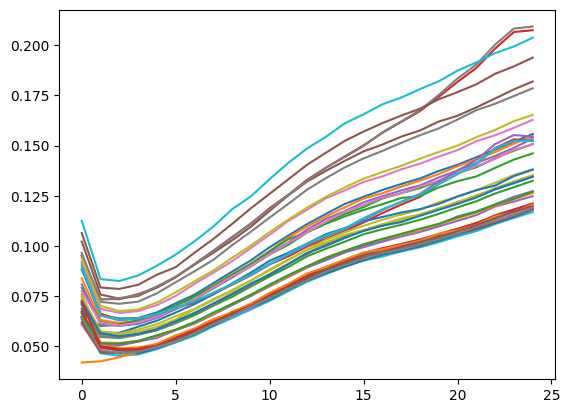

In [34]:
for i in range(40):
  plt.plot(X_train1[i])
plt.show()

In [ ]:
def preprocess(data, is_for_KNN = False):
    """Extract high-level features from the raw field data.

    Args:
        data_list: Directory to either train or test set
        mask_list: File path for the ground truth labels (expected CVS file)
        is_for_KNN: Binary flag for determining if the features are generated for KNN (TRUE) or Random Forest (FALSE)
    Returns:
        [type]: Tuple of lists composed of (features , field size) pairs for each field,
                where field size will be used performance analysis.
    """

    processed_data = []

    w1 = pywt.Wavelet("sym3")
    w2 = pywt.Wavelet("dmey")

    processed_data = []

    for item in data:

      item_2d = item.reshape(-1, 1)
      s = np.linalg.svd(item_2d, full_matrices=False, compute_uv=False)

      arr = item

      cA0, cD0 = pywt.dwt(arr, wavelet=w2, mode="constant")
      cAx, cDx = pywt.dwt(cA0[12:92], wavelet=w2, mode="constant")
      cAy, cDy = pywt.dwt(cAx[15:55], wavelet=w2, mode="constant")
      cAz, cDz = pywt.dwt(cAy[15:35], wavelet=w2, mode="constant")
      cAw2 = np.concatenate((cA0[12:92], cAx[15:55], cAy[15:35], cAz[15:25]), -1)
      cDw2 = np.concatenate((cD0[12:92], cDx[15:55], cDy[15:35], cDz[15:25]), -1)

      cA0, cD0 = pywt.dwt(arr, wavelet=w1, mode="constant")
      cAx, cDx = pywt.dwt(cA0[1:-1], wavelet=w1, mode="constant")
      cAy, cDy = pywt.dwt(cAx[1:-1], wavelet=w1, mode="constant")
      cAz, cDz = pywt.dwt(cAy[1:-1], wavelet=w1, mode="constant")
      cAw1 = np.concatenate((cA0, cAx, cAy, cAz), -1)
      cDw1 = np.concatenate((cD0, cDx, cDy, cDz), -1)

      dXdl = np.gradient(arr, axis=0)
      d2Xdl2 = np.gradient(dXdl, axis=0)
      d3Xdl3 = np.gradient(d2Xdl2, axis=0)


      fft = np.fft.fft(arr)
      real = np.real(fft)
      imag = np.imag(fft)
      ffts = np.fft.fft(s)
      reals = np.real(ffts)
      imags = np.imag(ffts)

      # The best Feature combination for Random Forest based regression
      out_rf = np.concatenate(
          [
              arr,
              dXdl,
              d2Xdl2,
              d3Xdl3,
              s,
              real,
              imag,
              reals,
              imags,
              cAw1,
              cAw2,
          ],
          -1,
      )

      # The best Feature combination for KNN based regression
      out_knn = np.concatenate(
          [
              arr,
              dXdl,
              d2Xdl2,
              d3Xdl3,
              s,
            real,
            imag,

        ],
        -1,
    )


      if is_for_KNN:
          processed_data.append(out_knn)
      else:
          processed_data.append(out_rf)

    return np.array(processed_data)


In [16]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
X_train1 = preprocess(X_train)
X_test1 = preprocess(X_test)

In [35]:
X_train1.shape

(543, 25)

In [ ]:
X_train1

array([[0.09322547, 0.06573642, 0.06280368, ..., 0.16939352, 0.17098113,
        0.17035111],
       [0.08041311, 0.06112393, 0.05966848, ..., 0.19701794, 0.19820379,
        0.19731858],
       [0.07302046, 0.05640257, 0.05503732, ..., 0.17387658, 0.17408728,
        0.17285867],
       ...,
       [0.09939327, 0.07435246, 0.07436822, ..., 0.21883037, 0.21811314,
        0.21772862],
       [0.13834483, 0.1109068 , 0.11243079, ..., 0.29828123, 0.29920609,
        0.29813703],
       [0.1348914 , 0.10810328, 0.10852624, ..., 0.29356829, 0.29267605,
        0.29303221]])

In [25]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train1 = scaler.fit_transform(X_train1)

# Transform the test data using the same scaler
X_test1 = scaler.transform(X_test1)


In [36]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(25, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2)  # No activation function for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Using mean squared error loss for regression

# Print model summary
model.summary()

# Train the model
model.fit(X_train1, y_train, epochs=200, batch_size=1, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 23, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 11, 64)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 704)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               90240     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                      

In [27]:
model.evaluate(X_test1, y_test)

5/5 [==============================] - 0s 20ms/step - loss: 1.0274 - mae: 0.6757


[1.0274059772491455, 0.675685465335846]

In [28]:
# Assuming 'model' is your TensorFlow model
model.save("/content/drive/MyDrive/BTP/Temp_mois2_Model")

5/5 [==============================] - 0s 3ms/step


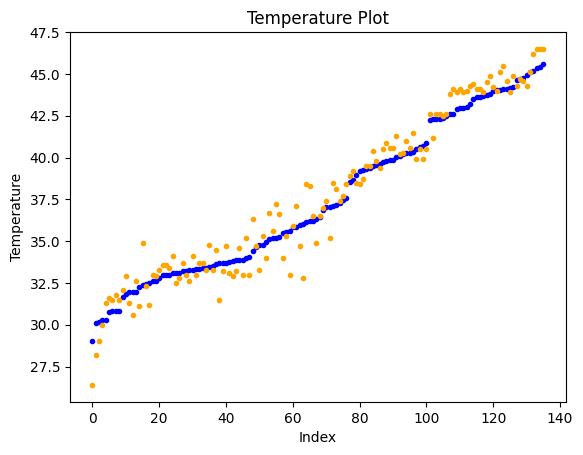

In [ ]:
y_test.shape
import matplotlib.pyplot as plt

# Get the indices that would sort array1
sorted_indices = np.argsort(model.predict(X_test1)[:,0])

# Sort array1 and array2 using the sorted indices
sorted_array1 = model.predict(X_test1)[:,0][sorted_indices]
sorted_array2 = np.array(y_test['soil_temperature'])[sorted_indices]

# Plotting the second component with dots
plt.plot(sorted_array1, '.', color='blue')
plt.plot(sorted_array2, '.', color='orange')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Temperature Plot')
plt.show()


5/5 [==============================] - 0s 6ms/step


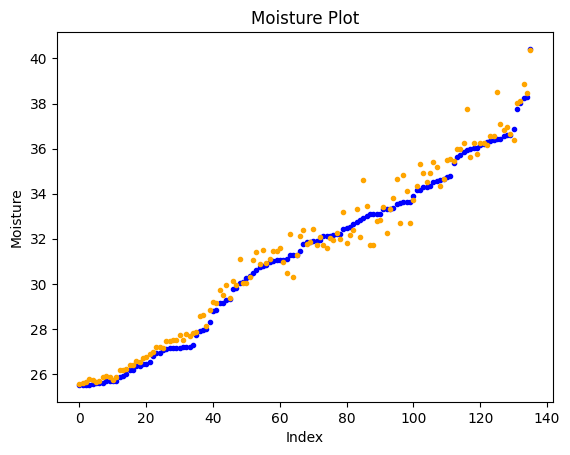

In [ ]:
y_test.shape
import matplotlib.pyplot as plt

# Get the indices that would sort array1
sorted_indices = np.argsort(model.predict(X_test1)[:,1])

# Sort array1 and array2 using the sorted indices
sorted_array1 = model.predict(X_test1)[:,1][sorted_indices]
sorted_array2 = np.array(y_test['soil_moisture'])[sorted_indices]

# Plotting the second component with dots
plt.plot(sorted_array1, '.', color='blue')
plt.plot(sorted_array2, '.', color='orange')
plt.xlabel('Index')
plt.ylabel('Moisture')
plt.title('Moisture Plot')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(1030, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2)  # No activation function for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Using mean squared error loss for regression

# Print model summary
model.summary()

# Train the model
model.fit(X_train1, y_train, epochs=1000, batch_size=1, validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1028, 64)          256       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 514, 64)           0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 32896)             0         
                                                                 
 dense_18 (Dense)            (None, 128)               4210816   
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 2)                 130       
                                                      

In [ ]:
model.evaluate(X_test1, y_test)

5/5 [==============================] - 0s 15ms/step - loss: 1.7123 - mae: 0.9557


[1.7123186588287354, 0.9557144045829773]

5/5 [==============================] - 0s 5ms/step


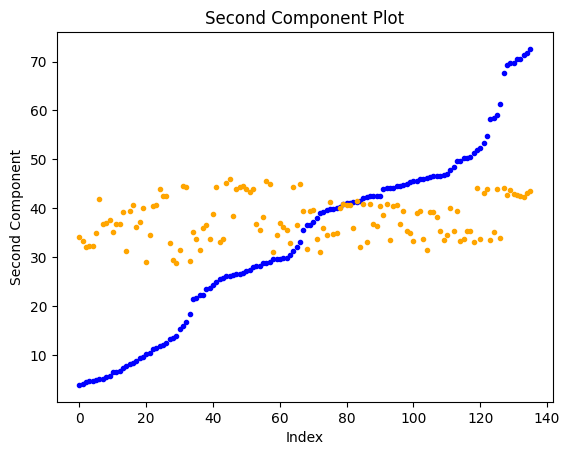

In [ ]:
y_test.shape
import matplotlib.pyplot as plt

# Get the indices that would sort array1
sorted_indices = np.argsort(model.predict(X_test1)[:,0])

# Sort array1 and array2 using the sorted indices
sorted_array1 = model.predict(X_test1)[:,0][sorted_indices]
sorted_array2 = np.array(y_test['soil_temperature'])[sorted_indices]

# Plotting the second component with dots
plt.plot(sorted_array1, '.', color='blue')
plt.plot(sorted_array2, '.', color='orange')
plt.xlabel('Index')
plt.ylabel('Second Component')
plt.title('Second Component Plot')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model architecture
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(1030,)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

# Print the model summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               131968    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 2)                 130       
                                                                 
Total params: 140354 (548.26 KB)
Trainable params: 140354 (548.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train1, y_train, epochs=1000, batch_size=1, validation_split=0.2)

Epoch 1/1000
434/434 [==============================] - 2s 4ms/step - loss: 264.5516 - mae: 13.1932 - val_loss: 99.3827 - val_mae: 8.0486
Epoch 2/1000
434/434 [==============================] - 1s 3ms/step - loss: 119.5335 - mae: 8.9179 - val_loss: 76.0023 - val_mae: 6.9455
Epoch 3/1000
434/434 [==============================] - 2s 4ms/step - loss: 96.7622 - mae: 7.9213 - val_loss: 78.9070 - val_mae: 6.8480
Epoch 4/1000
434/434 [==============================] - 2s 4ms/step - loss: 92.7051 - mae: 7.4072 - val_loss: 92.9502 - val_mae: 7.6260
Epoch 5/1000
434/434 [==============================] - 1s 3ms/step - loss: 85.2981 - mae: 7.2758 - val_loss: 90.3453 - val_mae: 7.6718
Epoch 6/1000
434/434 [==============================] - 1s 3ms/step - loss: 72.0944 - mae: 6.8766 - val_loss: 60.8462 - val_mae: 6.2474
Epoch 7/1000
434/434 [==============================] - 1s 3ms/step - loss: 67.6800 - mae: 6.5576 - val_loss: 54.5416 - val_mae: 5.8604
Epoch 8/1000
434/434 [=======================

In [ ]:
model.fit(X_train1, y_train, epochs=1000, batch_size=1, validation_split=0.2)

In [ ]:
model.evaluate(X_train1, y_train)

17/17 [==============================] - 0s 5ms/step - loss: 0.9659 - mae: 0.7388


[0.9659255146980286, 0.7388225793838501]

5/5 [==============================] - 0s 3ms/step


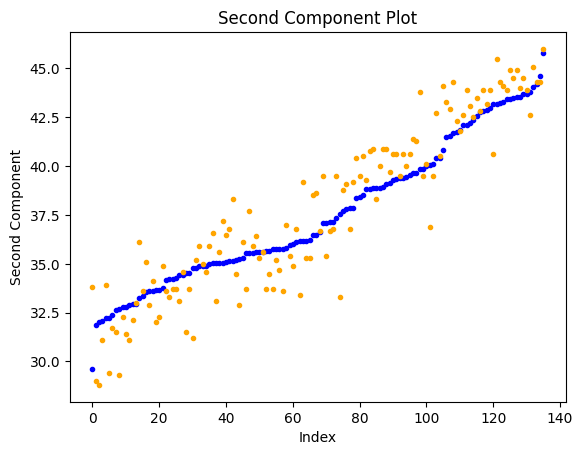

In [ ]:
y_test.shape
import matplotlib.pyplot as plt

# Get the indices that would sort array1
sorted_indices = np.argsort(model.predict(X_test1)[:,0])

# Sort array1 and array2 using the sorted indices
sorted_array1 = model.predict(X_test1)[:,0][sorted_indices]
sorted_array2 = np.array(y_test['soil_temperature'])[sorted_indices]

# Plotting the second component with dots
plt.plot(sorted_array1, '.', color='blue')
plt.plot(sorted_array2, '.', color='orange')
plt.xlabel('Index')
plt.ylabel('Second Component')
plt.title('Second Component Plot')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

# Train the model
rf_model.fit(X_train1, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test1)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 1.0598484667738914
Mean Absolute Error: 0.6357417279411748
Mean Squared Error: 1.1845283972518368
Mean Absolute Error: 0.6204340073529395


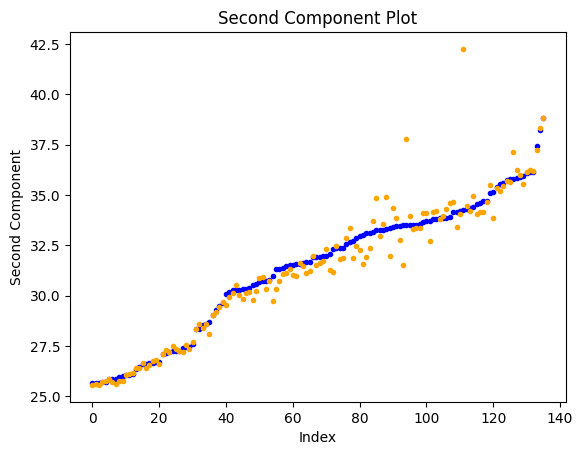

In [ ]:
y_test.shape
import matplotlib.pyplot as plt

# Get the indices that would sort array1
sorted_indices = np.argsort(rf_model.predict(X_test1)[:,1])

# Sort array1 and array2 using the sorted indices
sorted_array1 = rf_model.predict(X_test1)[:,1][sorted_indices]
sorted_array2 = np.array(y_test['soil_moisture'])[sorted_indices]

# Plotting the second component with dots
plt.plot(sorted_array1, '.', color='blue')
plt.plot(sorted_array2, '.', color='orange')
plt.xlabel('Index')
plt.ylabel('Second Component')
plt.title('Second Component Plot')
plt.show()


In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create the HistGradientBoosting regressor model
hist_gb_model = HistGradientBoostingRegressor()

# Train the model
hist_gb_model.fit(X_train, y_train[:,1])

# Predict on the test set
y_pred = hist_gb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test[:,1], y_pred)
mae = mean_absolute_error(y_test[:,1], y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 0.7105588726829769
Mean Absolute Error: 0.435193956636401


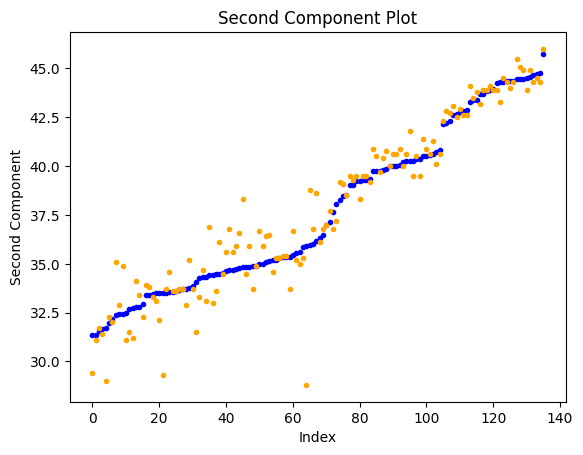

In [ ]:
y_test.shape
import matplotlib.pyplot as plt
model = rf_model
# Get the indices that would sort array1
sorted_indices = np.argsort(model.predict(X_test1)[:,0])

# Sort array1 and array2 using the sorted indices
sorted_array1 = model.predict(X_test1)[:,0][sorted_indices]
sorted_array2 = np.array(y_test['soil_temperature'])[sorted_indices]

# Plotting the second component with dots
plt.plot(sorted_array1, '.', color='blue')
plt.plot(sorted_array2, '.', color='orange')
plt.xlabel('Index')
plt.ylabel('Second Component')
plt.title('Second Component Plot')
plt.show()


In [ ]:
def preprocess(data_list):
    """Extract high-level features from the raw field data.

    Args:
        data_list: Directory to either train or test set
        mask_list: File path for the ground truth labels (expected CVS file)
        is_for_KNN: Binary flag for determining if the features are generated for KNN (TRUE) or Random Forest (FALSE)
    Returns:
        [type]: Tuple of lists composed of (features , field size) pairs for each field,
                where field size will be used performance analysis.
    """

    def _shape_pad(data):
        # This sub-function makes padding to have square fields sizes.
        # Not mandatory but eliminates the risk of calculation error in singular value decomposition,
        # padding by warping also improves the performance slightly.
        max_edge = np.max(image.shape[1:])
        shape = (max_edge, max_edge)
        padded = np.pad(data,((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))),"wrap")
        return padded

    filtering = SpectralCurveFiltering()
    w1 = pywt.Wavelet("sym3")
    w2 = pywt.Wavelet("dmey")

    processed_data = []
    average_edge = []

    for idx, (data) in enumerate(
        tqdm(
            zip(data_list),
            total=len(data_list),
            position=0,
            leave=True,
            desc="INFO: Preprocessing data ...",
        )
    ):
        image = data

        image = _shape_pad(image)

        s = np.linalg.svd(image, full_matrices=False, compute_uv=False)
        s0 = s[:, 0]
        s1 = s[:, 1]
        s2 = s[:, 2]
        s3 = s[:, 3]
        s4 = s[:, 4]
        dXds1 = s0 / (s1 + np.finfo(float).eps)


        arr = filtering(data)

        cA0, cD0 = pywt.dwt(arr, wavelet=w2, mode="constant")
        cAx, cDx = pywt.dwt(cA0[12:92], wavelet=w2, mode="constant")
        cAy, cDy = pywt.dwt(cAx[15:55], wavelet=w2, mode="constant")
        cAz, cDz = pywt.dwt(cAy[15:35], wavelet=w2, mode="constant")
        cAw2 = np.concatenate((cA0[12:92], cAx[15:55], cAy[15:35], cAz[15:25]), -1)
        cDw2 = np.concatenate((cD0[12:92], cDx[15:55], cDy[15:35], cDz[15:25]), -1)

        cA0, cD0 = pywt.dwt(arr, wavelet=w1, mode="constant")
        cAx, cDx = pywt.dwt(cA0[1:-1], wavelet=w1, mode="constant")
        cAy, cDy = pywt.dwt(cAx[1:-1], wavelet=w1, mode="constant")
        cAz, cDz = pywt.dwt(cAy[1:-1], wavelet=w1, mode="constant")
        cAw1 = np.concatenate((cA0, cAx, cAy, cAz), -1)
        cDw1 = np.concatenate((cD0, cDx, cDy, cDz), -1)

        dXdl = np.gradient(arr, axis=0)
        d2Xdl2 = np.gradient(dXdl, axis=0)
        d3Xdl3 = np.gradient(d2Xdl2, axis=0)


        fft = np.fft.fft(arr)
        real = np.real(fft)
        imag = np.imag(fft)
        ffts = np.fft.fft(s0)
        reals = np.real(ffts)
        imags = np.imag(ffts)

        # The best Feature combination for Random Forest based regression
        out_rf = np.concatenate(
            [
                arr,
                dXdl,
                d2Xdl2,
                d3Xdl3,
                dXds1,
                s0,
                s1,
                s2,
                s3,
                s4,
                real,
                imag,
                reals,
                imags,
                cAw1,
                cAw2,
            ],
            -1,
        )

        # The best Feature combination for KNN based regression
        out_knn = np.concatenate(
            [
                arr,
                dXdl,
                d2Xdl2,
                d3Xdl3,
                s0,
                s1,
                s2,
                s3,
                s4,
                real,
                imag,

            ],
            -1,
        )


        if is_for_KNN:
            processed_data.append(out_knn)
        else:
            processed_data.append(out_rf)

    return np.array(processed_data), np.array(average_edge)



class SpectralCurveFiltering: # Default class provided by the challenge organizers
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function=np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


In [ ]:
X_train_ = preprocess(X_train)

INFO: Preprocessing data ...:   0%|          | 0/543 [00:00<?, ?it/s]

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
import pandas as pd

# Read the first CSV file
df1 = pd.read_csv("/content/drive/MyDrive/BTP/submission_hybrid.csv")

# Read the second CSV file
df2 = pd.read_csv("/content/drive/MyDrive/BTP/submission_hybrid_knn.csv")

df2

,Label,Value
0,0_P,0.981137
1,0_K,0.952556
2,0_Mg,0.982475
3,0_pH,1.014134
4,1_P,0.961773
...,...,...
4611,1152_pH,0.972102
4612,1153_P,0.850299
4613,1153_K,0.891365
4614,1153_Mg,0.907568


In [ ]:

# Calculate the average of corresponding columns
df1['Value'] = (0.2 * df1['Value'] + 0.8 * df2['Value'])  # Adjust 'column_name' accordingly

# Store the new dataframe in a file
df1.to_csv("/content/drive/MyDrive/BTP/average_file.csv", index=False)


In [ ]:
df1

,Label,Value
0,0_P,0.981137
1,0_K,0.952556
2,0_Mg,0.982475
3,0_pH,1.014134
4,1_P,0.961773
...,...,...
4611,1152_pH,0.972652
4612,1153_P,0.854628
4613,1153_K,0.896038
4614,1153_Mg,0.909036
